# Steel Defect Segmentation with U-Net (ResNet18 Backbone)

Bu notebook, **Akbank Bootcamp** kapsamında hazırlanmış olup, klasik sınıflandırma yaklaşımının ötesine geçerek **çelik yüzeyindeki kusurların segmentasyonunu** hedeflemektedir.  
Böylece katılımcılar yalnızca bir görüntünün kusurlu olup olmadığını sınıflandırmayı değil, **hangi bölgelerin kusurlu olduğunu pikseller düzeyinde** öğrenme fırsatı bulur.  

📌 Bu yapı,kısmen daha **zor** olsa da aynı zamanda daha **öğretici** olması hedeflenmiştir:
- **Kaggle Severstal Steel Defect Detection** veri seti kullanılmıştır.
- Maskeler `preprocess.py` yardımıyla hazırlanır.
- PyTorch tabanlı **U-Net modeli (ResNet18 backbone)** geliştirilmiştir.
- Eğitimde **Focal Loss + Dice Loss** kombinasyonu kullanılmıştır. Bu sayede dengesiz sınıf dağılımı ile başa çıkılır.
- Eğitim süreci boyunca **Dice Score, Loss, LR grafikleri** kaydedilir.
- Sonuçlar hem **sayısal metrikler** hem de **niteliksel görselleştirmeler** (girdi görüntüsü + GT maske + model tahmini) ile raporlanır.

🔗 **GitHub Repo**: [Steel Defect Detection Repository](https://github.com/erdalgumuss/steel-defect-detection)  
🔗 **Kaggle Dataset**: [Severstal Steel Defect Detection](https://www.kaggle.com/competitions/severstal-steel-defect-detection)  

---


### 1) Kurulum ve Ortam Hazırlığı  

Bu bölümde gerekli kütüphaneler import edilir, `SEED` sabitlenerek **tekrarlanabilir sonuçlar** sağlanır.  
Ayrıca GPU/CPU durumu kontrol edilip `device` değişkeni ayarlanır.  


In [1]:
import os, gc, sys, math, random, json, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed()


### 2) Yol & Konfig  

Modelin eğitiminde kullanılacak **parametreler** (`CFG`) ve **dosya yolları** tanımlanır.  
- Resim boyutu (`HEIGHT`, `WIDTH`)  
- Sınıf sayısı (`NUM_CLASSES`)  
- Eğitim/validasyon ayrımı (`VAL_SPLIT`)  
- Batch size, epoch, öğrenme oranı, vs.  
- Dataset yolları (`TRAIN_CSV`, `TRAIN_DIR`, `TEST_DIR`)  

In [2]:
CFG = {
    "HEIGHT": 256,
    "WIDTH": 1600,
    "NUM_CLASSES": 4,
    "VAL_SPLIT": 0.2,
    "BATCH_SIZE": 8,
    "NUM_WORKERS": 2,
    "EPOCHS": 30,
    "LR": 3e-4,
    "WEIGHT_DECAY": 1e-5,
    "DECODER_MODE": "add",   # "add" | "concat"
    "PRETRAINED": True,
    "THRESHOLD": 0.5,
}

DATA_DIR = Path("../input/severstal-steel-defect-detection")
TRAIN_CSV = DATA_DIR / "train.csv"
TRAIN_DIR = DATA_DIR / "train_images"
TEST_DIR  = DATA_DIR / "test_images"       # submission için lazımsa
WORK_DIR  = Path("/kaggle/working")


## 3. Veri Keşfi (EDA) ve Görselleştirme  

Bu bölümde dataset üzerinde **istatistiksel analiz** ve **görselleştirme** yapılmaktadır:  

- **Defektli / defektsiz görüntü oranı** → Veri dengesizliği kontrolü  
- **Sınıf bazında dağılım** → Hangi defekt tipleri daha sık görülüyor?  
- **Çoklu kusurlar** → Bir görüntüde birden fazla sınıf bulunma oranı  
- **Histogram & Pie Chart** → Görselleştirilmiş dağılımlar  

📌 Bu analizler sayesinde:
- Veri **dengesizlikleri** ortaya çıkar.  
- Modelin **hangi sınıflarda zorlanabileceği** öngörülür.  
- Eğitim öncesi **stratejik kararlar** (ör. class weights, augmentation) alınabilir.  


In [3]:
import pandas as pd

# CSV oku
df = pd.read_csv(TRAIN_CSV)
print("CSV boyutu:", df.shape)
print("İlk 5 satır:")
df.head()


CSV boyutu: (7095, 3)
İlk 5 satır:


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


Toplam görüntü: 12568
Defektli görüntü: 6666
Defektsiz görüntü: 5902


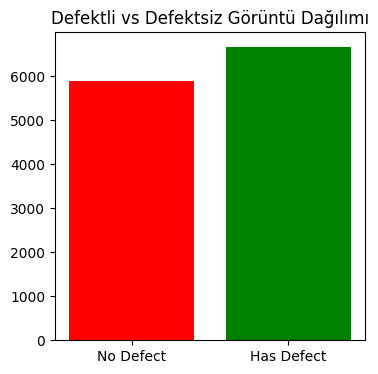

In [4]:
import os
import matplotlib.pyplot as plt

# Tüm train klasöründeki görseller
all_images = os.listdir("../input/severstal-steel-defect-detection/train_images")
all_images = [img for img in all_images if img.endswith(".jpg")]

# train.csv'deki defektli görseller
defect_images = df["ImageId"].unique().tolist()

# Defektsizleri bul
no_defect_images = set(all_images) - set(defect_images)

print(f"Toplam görüntü: {len(all_images)}")
print(f"Defektli görüntü: {len(defect_images)}")
print(f"Defektsiz görüntü: {len(no_defect_images)}")

# Bar plot
plt.figure(figsize=(4,4))
plt.bar(["No Defect", "Has Defect"], [len(no_defect_images), len(defect_images)], color=["red", "green"])
plt.title("Defektli vs Defektsiz Görüntü Dağılımı")
plt.show()


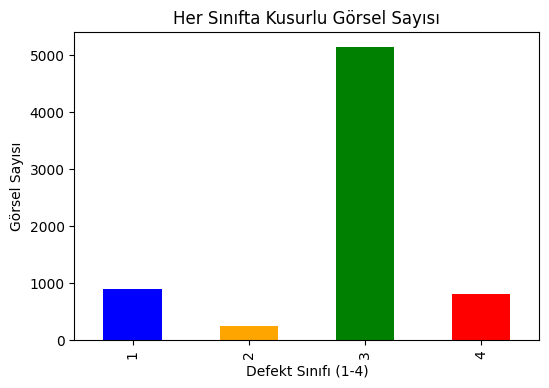

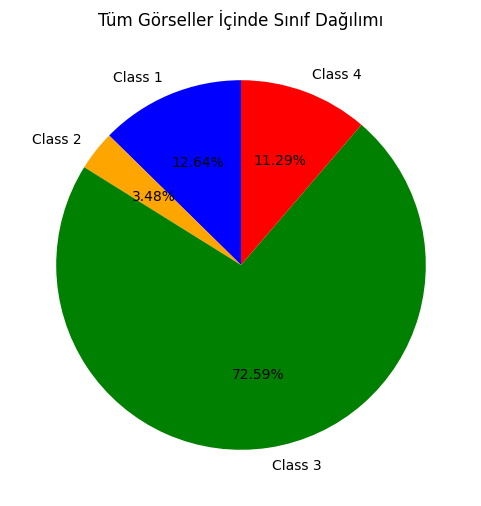

📊 Sınıf Bazında Kusurlu Görsel Sayıları:
ClassId
1     897
2     247
3    5150
4     801
Name: ImageId, dtype: int64

📊 Sınıf Bazında Oranlar (%):
ClassId
1    13.46
2     3.71
3    77.26
4    12.02
Name: ImageId, dtype: float64


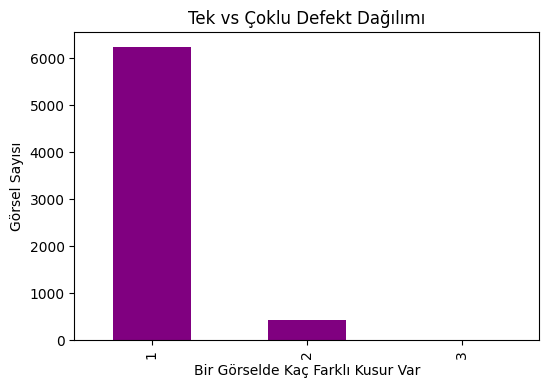

📊 Tek defektli görseller: 6239
📊 Çoklu defektli görseller: 427
         Kusurlu Görsel Sayısı  Tüm Görsellere Oranı (%)
ClassId                                                 
1                          897                     13.46
2                          247                      3.71
3                         5150                     77.26
4                          801                     12.02


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# train.csv yükle
df = pd.read_csv("../input/severstal-steel-defect-detection/train.csv")

# Sınıf bazında en az bir kusuru olan görsellerin sayısı
class_counts = df.loc[df["EncodedPixels"].notnull()] \
                 .groupby("ClassId")["ImageId"].nunique()

# Toplam görsel sayısı
total_images = df["ImageId"].nunique()

# Grafik 1: Her sınıfta kusurlu görsel sayısı
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["blue","orange","green","red"])
plt.title("Her Sınıfta Kusurlu Görsel Sayısı")
plt.ylabel("Görsel Sayısı")
plt.xlabel("Defekt Sınıfı (1-4)")
plt.show()
# Oranlar (tüm dataset üzerinden)
class_ratios = class_counts / total_images * 100

# Grafik 2: Pie chart
plt.figure(figsize=(6,6))
plt.pie(class_ratios, labels=[f"Class {c}" for c in class_counts.index],
        autopct="%.2f%%", startangle=90, colors=["blue","orange","green","red"])
plt.title("Tüm Görseller İçinde Sınıf Dağılımı")
plt.show()



print("📊 Sınıf Bazında Kusurlu Görsel Sayıları:")
print(class_counts)
print("\n📊 Sınıf Bazında Oranlar (%):")
print(class_ratios.round(2))

# Görsel başına farklı sınıf sayısı
defects_per_image = df.loc[df["EncodedPixels"].notnull()] \
                      .groupby("ImageId")["ClassId"].nunique()

# Histogram
plt.figure(figsize=(6,4))
defects_per_image.value_counts().sort_index().plot(kind="bar", color="purple")
plt.xlabel("Bir Görselde Kaç Farklı Kusur Var")
plt.ylabel("Görsel Sayısı")
plt.title("Tek vs Çoklu Defekt Dağılımı")
plt.show()

print("📊 Tek defektli görseller:", (defects_per_image==1).sum())
print("📊 Çoklu defektli görseller:", (defects_per_image>1).sum())

summary = pd.DataFrame({
    "Kusurlu Görsel Sayısı": class_counts,
    "Tüm Görsellere Oranı (%)": class_ratios.round(2)
})
print(summary)


### 4. RLE Yardımcıları & Maske İnşa  

Bu bölümde, Kaggle’daki `train.csv` dosyasında verilen **Run-Length Encoding (RLE)** maskelerini çözümlemek ve yeniden encode etmek için fonksiyonlar tanımlanır:  

- **`rle_decode(mask_rle)`** → RLE string’i ikili maske matrisine (H×W) çevirir.  
- **`rle_encode(mask)`** → İkili maske matrisini tekrar RLE string’e dönüştürür (submission için gerekli).  
- **`build_masks(image_id, df)`** → Bir görüntüye ait tüm sınıf maskelerini birleştirip `(H, W, C)` boyutunda çok kanallı maske döndürür.  

📌 Ek olarak:  
- `matplotlib` ile görselleştirme yapılır: Orijinal görsel, her sınıfın maskesi ve renkli overlay gösterilir.  
- Bu adım, **verinin doğru işlendiğini ve maskelerin doğru oturduğunu** doğrulamak için oldukça önemlidir.  


In [6]:
def rle_decode(mask_rle: str, shape=(CFG["HEIGHT"], CFG["WIDTH"])) -> np.ndarray:
    if not isinstance(mask_rle, str) or mask_rle.strip()=="":
        return np.zeros(shape, dtype=np.uint8)
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.asarray(starts) - 1
    ends   = starts + np.asarray(lengths)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")

def rle_encode(mask: np.ndarray) -> str:
    pixels = mask.flatten(order="F")
    pads = np.pad(pixels, (1,1), constant_values=0)
    changes = np.where(pads[1:] != pads[:-1])[0] + 1
    starts, ends = changes[::2], changes[1::2]
    lengths = ends - starts
    if len(starts)==0:
        return ""
    return " ".join(f"{s} {l}" for s,l in zip(starts, lengths))

def build_masks(image_id: str, df: pd.DataFrame,
                shape=(CFG["HEIGHT"], CFG["WIDTH"]),
                num_classes=CFG["NUM_CLASSES"]) -> np.ndarray:
    m = np.zeros((shape[0], shape[1], num_classes), dtype=np.uint8)
    for c in range(1, num_classes+1):
        rles = df.loc[(df["ImageId"]==image_id) & (df["ClassId"]==c), "EncodedPixels"]
        if rles.notnull().any():
            for rle in rles:
                m[..., c-1] |= rle_decode(rle, shape)
    return m


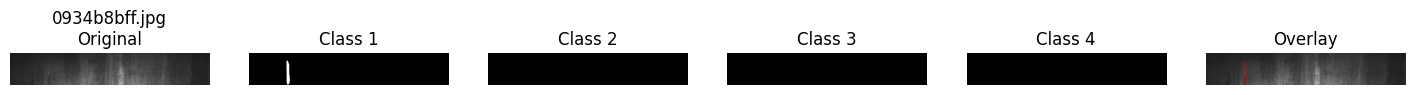

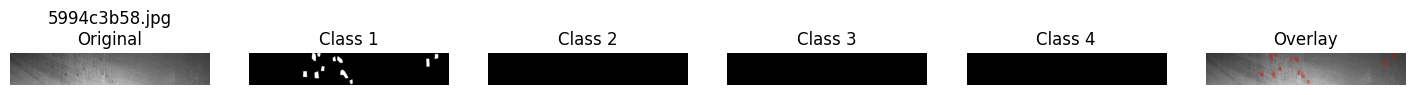

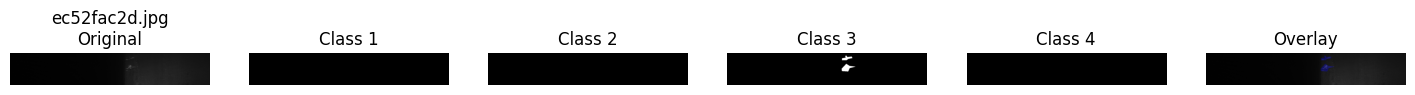

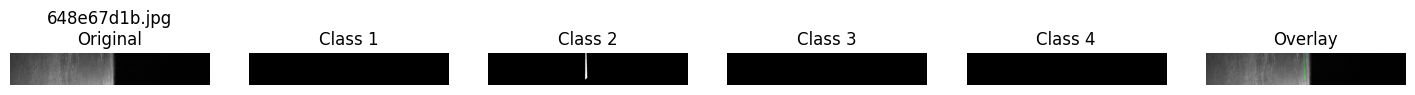

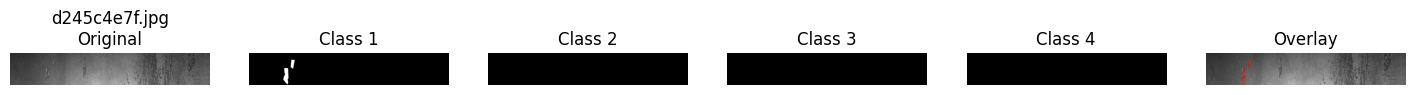

In [7]:
import cv2
import matplotlib.pyplot as plt

sample_images = df["ImageId"].drop_duplicates().sample(5, random_state=42).tolist()

for image_id in sample_images:
    img_path = TRAIN_DIR / image_id
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    masks = build_masks(image_id, df)

    plt.figure(figsize=(18,4))
    plt.subplot(1,6,1)
    plt.imshow(img)
    plt.title(f"{image_id}\nOriginal")
    plt.axis("off")

    # Sınıf maskeleri
    for i in range(4):
        plt.subplot(1,6,i+2)
        plt.imshow(masks[..., i], cmap="gray")
        plt.title(f"Class {i+1}")
        plt.axis("off")

    # Overlay
    overlay = img.copy()
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]  # R, G, B, Sarı
    for i in range(4):
        mask = masks[..., i].astype(bool)
        overlay[mask] = (0.7*overlay[mask] + 0.3*np.array(colors[i])).astype(np.uint8)

    plt.subplot(1,6,6)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


### 5. Transformlar (Data Augmentation)

Modelin **aşırı öğrenmesini (overfitting)** engellemek ve farklı varyasyonlara karşı daha dayanıklı hale gelmesini sağlamak için `Albumentations` kütüphanesi ile transformlar uygulanır.

- **Eğitim Transformları (`get_train_transforms`)**  
  - `CropNonEmptyMaskIfExists`: Maske içeren kısımdan kırpma (daha dengeli öğrenme için).  
  - `HorizontalFlip`: Yatay çevirme.  
  - `Affine`: Küçük ölçek, kaydırma ve döndürme işlemleri.  
  - `GaussianBlur`: Gürültüye dayanıklılık için bulanıklaştırma.  
  - `RandomBrightnessContrast`: Parlaklık/kontrast değişiklikleri.  
  - `Resize`: Sabit boyuta ölçekleme.  
  - `Normalize + ToTensorV2`: PyTorch uyumlu tensor ve normalizasyon.

- **Valid Transformları (`get_valid_transforms`)**  
  - Sadece `Resize` ve `Normalize` işlemleri (augmentation yok).

📌 Ayrıca `visualize_random_aug` fonksiyonu ile:  
- Bir görsel + maskeler alınır.  
- Augmentation sonrası overlay gösterilir.  
- Böylece uygulanan augmentations’ın **doğru ve etkili olup olmadığı** görsel olarak kontrol edilebilir.  


In [8]:
def get_train_transforms(H=CFG["HEIGHT"], W=CFG["WIDTH"]):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.9,1.1), translate_percent=(0.02,0.02), rotate=(-5,5), p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.RandomBrightnessContrast(p=0.4),
        A.Resize(H, W, interpolation=1),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ], is_check_shapes=False)

def get_valid_transforms(H=CFG["HEIGHT"], W=CFG["WIDTH"]):
    return A.Compose([
        A.Resize(H, W, interpolation=1),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ])


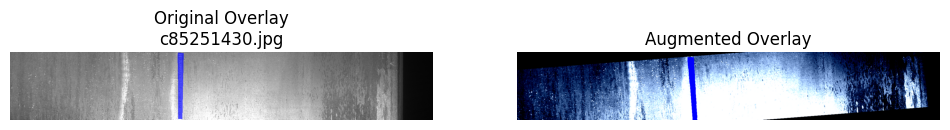

In [9]:
import random

def visualize_random_aug(df, train_dir=TRAIN_DIR, transforms=get_train_transforms()):
    # Random bir görsel seç
    image_id = random.choice(df["ImageId"].unique().tolist())
    img_path = train_dir / image_id
    
    # Görseli oku
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Maske oluştur
    masks = build_masks(image_id, df)   # (H,W,4)
    
    # Albumentations ile augment et
    aug = transforms(image=img, masks=[masks[...,i] for i in range(4)])
    aug_img = aug["image"].permute(1,2,0).cpu().numpy()   # CHW -> HWC
    aug_masks = np.stack(aug["masks"], axis=-1)           # geri birleştir
    
    # Overlay fonksiyonu
    def overlay_image(base, masks, alpha=0.3):
        colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]
        overlay = base.copy()
        for i in range(masks.shape[-1]):
            mask = masks[..., i].astype(bool)
            overlay[mask] = (alpha*overlay[mask] + (1-alpha)*np.array(colors[i])).astype(np.uint8)
        return overlay
    
    orig_overlay = overlay_image(img, masks)
    aug_overlay  = overlay_image(aug_img, aug_masks)
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(orig_overlay)
    plt.title(f"Original Overlay\n{image_id}")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(aug_overlay)
    plt.title("Augmented Overlay")
    plt.axis("off")
    
    plt.show()

# Kullanım: her çalıştırmada random bir örnek gösterir
visualize_random_aug(df)


### 6. Dataset Sınıfı ve DataLoader

Modelin eğitimi için özel bir **PyTorch `Dataset` sınıfı** tanımlanmıştır:

- **`SteelDefectDataset`**
  - Görseller **grayscale** okunur ve opsiyonel olarak **3 kanala kopyalanır** (ImageNet pretrained backbone uyumluluğu için).  
  - Maskeler `build_masks` fonksiyonu ile RLE’den çözülüp çok-kanallı (C=4) formatta üretilir.  
  - `Albumentations` transformları hem görüntü hem de maskeye birlikte uygulanır.
  - Geri dönüş: `(image, mask, meta)`  
    - `image`: `(3,H,W)`  
    - `mask`: `(4,H,W)`  
    - `meta`: Görsel kimliği (id).

- **Collate Function**
  - `collate_fn`: batch içindeki img/mask/metaları ayrı listelerden tensör stack’leri haline getirir.  

- **DataLoader**
  - Eğitim ve valid split `train_test_split` ile yapılır.  
  - `train_loader`: shuffle=True, augmentation aktif.  
  - `valid_loader`: shuffle=False, sadece resize/normalize.  

📌 **Test aşaması**:  
Kod sonunda bir batch örneği çekilip `images.shape`, `masks.shape` ve `meta` bilgisi ekrana basılarak veri akışının doğru çalıştığı kontrol edilmiştir.


In [10]:
class SteelDefectDataset(Dataset):
    def __init__(self, image_ids, image_dir: Path, df: pd.DataFrame, transforms=None, load_rgb=True):
        self.image_ids = list(image_ids)
        self.image_dir = image_dir
        self.df = df
        self.transforms = transforms
        self.load_rgb = load_rgb

    def __len__(self):
        return len(self.image_ids)

    def _read_image(self, image_id):
        img = cv2.imread(str(self.image_dir / image_id), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(image_id)
        if self.load_rgb:
            img = np.repeat(img[..., None], 3, axis=2)  # (H,W,3)
        return img

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img = self._read_image(image_id)
        mask = build_masks(image_id, self.df)  # (H,W,C)

        if self.transforms:
            out = self.transforms(image=img, mask=mask)
            img, mask = out["image"], out["mask"].permute(2,0,1)  # -> (C,H,W)
        else:
            img = torch.from_numpy(img.transpose(2,0,1)).float()
            mask = torch.from_numpy(mask.transpose(2,0,1)).float()

        meta = {"image_id": image_id}
        return img, mask, meta


# --- Collate function ---
def collate_fn(batch):
    images, masks, metas = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks, metas


# --- Dataset & DataLoader test ---
train_ids, valid_ids = train_test_split(
    df["ImageId"].unique(),
    test_size=CFG["VAL_SPLIT"],
    random_state=SEED
)

train_ds = SteelDefectDataset(train_ids, TRAIN_DIR, df, transforms=get_train_transforms())
valid_ds = SteelDefectDataset(valid_ids, TRAIN_DIR, df, transforms=get_valid_transforms())

train_loader = DataLoader(train_ds, batch_size=CFG["BATCH_SIZE"],
                          shuffle=True, num_workers=CFG["NUM_WORKERS"],
                          collate_fn=collate_fn)

valid_loader = DataLoader(valid_ds, batch_size=CFG["BATCH_SIZE"],
                          shuffle=False, num_workers=CFG["NUM_WORKERS"],
                          collate_fn=collate_fn)


# --- Test ---
batch = next(iter(train_loader))
images, masks, metas = batch

print("Images shape:", images.shape)   # (B, 3, H, W)
print("Masks shape:", masks.shape)     # (B, 4, H, W)
print("Meta örnek:", metas[0])


Images shape: torch.Size([8, 3, 256, 1600])
Masks shape: torch.Size([8, 4, 256, 1600])
Meta örnek: {'image_id': '843f0ae15.jpg'}


### 7. Train/Validation Split

Veri seti **görsel bazında** train/validation olarak ikiye ayrılmıştır:  

- **Stratify**:  
  - `any_defect` etiketi oluşturularak, içinde en az bir defekt olan görseller `1`, defektsiz olanlar `0` olarak işaretlenmiştir.  
  - Böylece train/val split yapılırken **defektli vs defektsiz görüntü oranı korunmuştur**.  

- **DataLoader Tanımları**:  
  - `train_loader`: augment edilmiş veriler, shuffle=True.  
  - `val_loader`: sadece resize+normalize, shuffle=False.  

📌 Bu yaklaşım, özellikle **az sayıda kusurlu görsel** bulunan sınıflarda validation setinin daha temsil edici olmasını sağlar.


In [11]:
all_ids = df["ImageId"].unique()
any_defect = df.groupby("ImageId")["EncodedPixels"].apply(lambda s: s.notnull().any()).astype(int)
train_ids, val_ids = train_test_split(all_ids, test_size=CFG["VAL_SPLIT"],
                                      random_state=SEED, stratify=any_defect.loc[all_ids])

train_ds = SteelDefectDataset(train_ids, TRAIN_DIR, df, transforms=get_train_transforms())
val_ds   = SteelDefectDataset(val_ids,   TRAIN_DIR, df, transforms=get_valid_transforms())

train_loader = DataLoader(train_ds, batch_size=CFG["BATCH_SIZE"], shuffle=True,
                          num_workers=CFG["NUM_WORKERS"], pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["BATCH_SIZE"], shuffle=False,
                          num_workers=CFG["NUM_WORKERS"], pin_memory=True)


### 8. Model: UNet + ResNet18 Encoder

Bu blokta segmentasyon modeli tanımlanmaktadır. Model, **U-Net mimarisi** ile **ResNet18 backbone**’u birleştirerek çelik yüzeyindeki kusurların segmentasyonunu hedefler.  

#### 🔹 Encoder (ResNet18 Backbone)
- `torchvision.models.resnet18` tabanlıdır.
- **conv1, bn1, relu, layer1–4** katmanları encoder olarak kullanılır.
- `avgpool` ve `fc` katmanları çıkarılır (UNet için gerekli değil).  
- Bu yapı sayesinde **ImageNet pretrained ağırlıklarından** faydalanılır.

#### 🔹 Decoder (Skip Connections)
- İki farklı mod desteği vardır:
  - **"add" modu**: Skip connection’lar *element-wise toplama* ile birleştirilir → daha hafif, hızlı.
  - **"concat" modu**: Skip connection’lar *kanal bazında birleştirilir* → daha güçlü ama parametre sayısı yüksek.
- Her upsampling bloğu: `ConvTranspose2d → BatchNorm2d → ReLU (+ Dropout opsiyonel)`.

#### 🔹 Çıkış Katmanı
- `Conv2d(64, num_classes, 1)` ile çıktı üretilir.
- `F.interpolate` ile sonuç tekrar giriş boyutuna `(H,W)` ölçeklenir.  
- Böylece model doğrudan maske boyutunda tahmin yapar.

---

✅ Bu yapı ile:
- Hem **önceden öğrenilmiş ResNet18 özelliklerinden** faydalanılır,  
- Hem de **U-Net’in skip-connection mimarisi** ile segmentasyon başarısı artırılır.  


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class UNetResNet18(nn.Module):
    def __init__(self, num_classes=CFG["NUM_CLASSES"], pretrained=True, decoder_mode="add", dropout=0.0):
        super().__init__()
        # Encoder backbone
        base = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        del base.fc, base.avgpool  # UNet'te kullanılmıyor

        self.enc1 = nn.Sequential(base.conv1, base.bn1, base.relu)
        self.enc2 = nn.Sequential(base.maxpool, base.layer1)
        self.enc3 = base.layer2
        self.enc4 = base.layer3
        self.enc5 = base.layer4

        self.mode = decoder_mode

        def up_block(in_ch, out_ch, use_concat=False):
            layers = [nn.ConvTranspose2d(in_ch, out_ch, 2, 2),
                      nn.BatchNorm2d(out_ch),
                      nn.ReLU(inplace=True)]
            if dropout > 0:
                layers.append(nn.Dropout2d(p=dropout))
            if use_concat:
                layers += [nn.Conv2d(out_ch*2, out_ch, 3, padding=1),
                           nn.BatchNorm2d(out_ch),
                           nn.ReLU(inplace=True)]
            return nn.Sequential(*layers)

        if self.mode == "add":
            self.up4 = up_block(512,256)
            self.up3 = up_block(256,128)
            self.up2 = up_block(128,64)
            self.up1 = up_block(64,64)
        else:  # concat
            self.up4 = up_block(512,256, use_concat=True)
            self.up3 = up_block(256,128, use_concat=True)
            self.up2 = up_block(128,64, use_concat=True)
            self.up1 = up_block(64,64, use_concat=True)

        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        # Decoder
        if self.mode == "add":
            d4 = self.up4(e5) + e4
            d3 = self.up3(d4) + e3
            d2 = self.up2(d3) + e2
            d1 = self.up1(d2) + e1
        else:  # concat
            d4 = self.up4(torch.cat([F.interpolate(e5, size=e4.shape[2:], mode="bilinear", align_corners=False), e4],1))
            d3 = self.up3(torch.cat([F.interpolate(d4, size=e3.shape[2:], mode="bilinear", align_corners=False), e3],1))
            d2 = self.up2(torch.cat([F.interpolate(d3, size=e2.shape[2:], mode="bilinear", align_corners=False), e2],1))
            d1 = self.up1(torch.cat([F.interpolate(d2, size=e1.shape[2:], mode="bilinear", align_corners=False), e1],1))

        out = self.final(d1)
        out = F.interpolate(out, size=x.shape[2:], mode="bilinear", align_corners=False)
        return out



### 9) Loss Fonksiyonları ve Metrikler

Bu projede **class imbalance** sorununu çözmek ve segmentasyon kalitesini artırmak için 
**Focal Loss + Dice Loss** kombinasyonu kullanıyoruz.  

- **DiceLoss**
  - Segmentasyon için yaygın kullanılan metrik. 
  - Küçük kusurların (maskelerin) önemini artırır.
  - `smooth` parametresi küçük maskelerde sıfır bölme hatalarını engeller.

- **WeightedFocalDiceLoss**
  - Focal Loss: Dengesiz sınıflarda zor örneklere daha fazla ağırlık verir.  
  - Dice Loss: Maske tahminlerini geometrik olarak daha iyi hizalar.  
  - `class_weights`: Veri setindeki nadir görülen kusurlara daha fazla ağırlık verir.  
  - `gamma`: Focal Loss odaklama parametresi.  
  - `lam_f` ve `lam_d`: Focal vs Dice ağırlıkları (kombinasyon katsayıları).  
  - Opsiyonel olarak `return_details=True` ile loss’un parçaları (focal, dice) ayrı ayrı incelenebilir.

- **dice_coefficient**
  - Tüm batch için ortalama Dice skorunu hesaplar.
  - Eğitim ve validasyon takibinde kullanılır.

- **dice_per_class**
  - Her kusur sınıfı için ayrı ayrı Dice skorları döndürür.
  - Özellikle dengesiz datasetlerde hangi sınıfın zorlandığını anlamak için önemlidir.


In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth=smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        p = probs.view(probs.size(0), probs.size(1), -1)
        t = targets.view(targets.size(0), targets.size(1), -1)
        inter = (p*t).sum(2); den = p.sum(2)+t.sum(2)
        dice = (2*inter + self.smooth) / (den + self.smooth)
        return 1.0 - dice.mean()

class WeightedFocalDiceLoss(nn.Module):
    def __init__(self, class_weights=None, gamma=2.0, lam_f=0.7, lam_d=0.3):
        super().__init__()
        self.w = class_weights
        self.g = gamma
        self.lf = lam_f
        self.ld = lam_d
        self.dice = DiceLoss()

    def forward(self, logits, targets, return_details=False):
        probs = torch.sigmoid(logits)
        eps = 1e-8

        # BCE
        bce = -(targets * torch.log(probs + eps) +
                (1 - targets) * torch.log(1 - probs + eps))

        # Focal modülasyonu
        pt = torch.where(targets == 1, probs, 1 - probs)
        fw = (1 - pt) ** self.g

        if self.w is not None:
            fw = fw * logits.new_tensor(self.w).view(1, -1, 1, 1)

        focal = (fw * bce).mean()
        dice = self.dice(logits, targets)

        loss = self.lf * focal + self.ld * dice

        if return_details:
            return loss, {"focal": focal.item(), "dice": dice.item()}
        return loss

@torch.no_grad()
def dice_coefficient(logits, targets, thr=CFG["THRESHOLD"], eps=1e-6):
    probs = torch.sigmoid(logits); preds = (probs>thr).float()
    inter = (preds*targets).sum((2,3)); den = preds.sum((2,3))+targets.sum((2,3))
    dice = (2*inter+eps)/(den+eps)
    return dice.mean()

@torch.no_grad()
def dice_per_class(logits, targets, thr=CFG["THRESHOLD"], eps=1e-6):
    probs = torch.sigmoid(logits); preds = (probs>thr).float()
    inter = (preds*targets).sum((0,2,3)); den = preds.sum((0,2,3))+targets.sum((0,2,3))
    return ((2*inter+eps)/(den+eps)).cpu().tolist()


### 10) Eğitim Motoru (Training Engine)

Bu bölümde modelimizin eğitim döngüsünü oluşturan fonksiyonları tanımlıyoruz.  
Kod üç ana parçadan oluşuyor:

---

#### 🔹 1. Epoch Fonksiyonları
- **`train_one_epoch`**:  
  - Modeli `train` moduna alır.  
  - Her batch için forward → loss → backward → optimizer step adımlarını uygular.  
  - Ortalama **loss** ve **Dice score** değerlerini döner.  

- **`validate_one_epoch`**:  
  - Modeli `eval` moduna alır.  
  - Gradients hesaplanmaz (`@torch.no_grad()`).  
  - Validasyon seti üzerinde loss ve dice skorlarını döner.  

Her iki fonksiyon da dataset’ten gelen `(imgs, masks, meta)` formatıyla uyumludur.  

---

#### 🔹 2. EarlyStopping
- Overfitting’i önlemek için kullanılır.  
- `mode="max"` → en yüksek **Dice skorunu** arar.  
- Belirlenen patience kadar iyileşme olmazsa eğitim durdurulur.  

---

#### 🔹 3. fit() Fonksiyonu
- Ana eğitim döngüsünü yönetir.  
- Her epoch’ta:
  - `train_one_epoch` ve `validate_one_epoch` çalışır.  
  - **ReduceLROnPlateau** scheduler val dice üzerinden güncellenir.  
  - `history` sözlüğüne train/valid metrikleri kaydedilir.  
  - En iyi Dice skoru elde edilirse model kaydedilir (`best_model.pth`).  
  - EarlyStopping tetiklenirse eğitim durur.  

---

#### 🔹 4. Uyum Kontrolleri
- **Dataset** → `(imgs, masks, meta)` → uyumlu.  
- **Model** → `(B, NUM_CLASSES, H, W)` logits → uyumlu.  
- **Loss** → `(logits, targets)` bekliyor → uyumlu.  
- **Metrikler** → `dice_coefficient` ile hesaplanıyor.  
- **Scheduler** → val dice üzerinden güncelleniyor.  

---

✅ Bu yapı sayesinde eğitim süreci hem takip edilebilir hem de erken durdurma & LR azaltma gibi optimizasyon teknikleri otomatik uygulanır.


In [14]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    run_loss, run_dice, n = 0.0, 0.0, 0
    for imgs, masks, _ in tqdm(loader, desc="Train", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()
        bs = imgs.size(0); n += bs
        run_loss += loss.item() * bs
        run_dice += dice_coefficient(out, masks).item() * bs
    return {"loss": run_loss/n, "dice": run_dice/n}


@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    run_loss, run_dice, n = 0.0, 0.0, 0
    for imgs, masks, _ in tqdm(loader, desc="Valid", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        out = model(imgs)
        loss = criterion(out, masks)
        bs = imgs.size(0); n += bs
        run_loss += loss.item() * bs
        run_dice += dice_coefficient(out, masks).item() * bs
    return {"loss": run_loss/n, "dice": run_dice/n}


class EarlyStopping:
    def __init__(self, patience=5, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.count = 0
        self.stop = False

    def __call__(self, score):
        if self.best is None:
            self.best = score; self.count = 0
        else:
            improve = (score > self.best) if self.mode=="max" else (score < self.best)
            if improve:
                self.best = score; self.count = 0
            else:
                self.count += 1
                if self.count >= self.patience:
                    self.stop = True


def fit(model, train_loader, val_loader, optimizer, scheduler, criterion, device,
        num_epochs=CFG["EPOCHS"], early_stopping_patience=5, save_path="best_model.pth"):
    early_stopping = EarlyStopping(patience=early_stopping_patience, mode="max")
    best_dice = -1.0

    history = {"train": [], "valid": []}

    for epoch in range(1, num_epochs+1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_metrics   = validate_one_epoch(model, val_loader, criterion, device)

        # per-class dice ekle
        all_val_dice = []
        for imgs, masks, _ in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            out = model(imgs)
            all_val_dice.append(dice_per_class(out, masks))
        val_metrics["per_class_dice"] = np.mean(all_val_dice, axis=0).tolist()

        scheduler.step(val_metrics["dice"])

        print(f"Train Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}")
        print(f"Valid Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}")

        history["train"].append({**train_metrics, "lr": optimizer.param_groups[0]["lr"]})
        history["valid"].append(val_metrics)

        if val_metrics["dice"] > best_dice:
            best_dice = val_metrics["dice"]
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved at epoch {epoch} (dice={best_dice:.4f})")

        early_stopping(val_metrics["dice"])
        if early_stopping.stop:
            print("⏹️ Early stopping triggered.")
            break

    print(f"Training finished. Best Dice = {best_dice:.4f}")
    return history


### 📊 Eğitim Grafiklerinin Görselleştirilmesi

- `plot_history` fonksiyonu, eğitim sırasında toplanan `history` sözlüğünden şu grafikleri çizer:
  - **Genel Dice skoru** (train & valid)  
  - **Loss değerleri** (train & valid)  
  - **Learning Rate değişimi**  
  - (opsiyonel) **Sınıf bazlı Dice skorları**, eğer `history` içinde tutuluyorsa.  
- Grafikler hem notebook içinde gösterilir (`plt.show`) hem de PNG olarak kaydedilir.  
- Bu sayede hem genel performans hem de sınıf bazlı başarım görselleştirilebilir.  


In [15]:
def plot_history(history, out_dir=WORK_DIR, show=True):
    tr_d = [e["dice"] for e in history["train"]]
    va_d = [e["dice"] for e in history["valid"]]
    tr_l = [e["loss"] for e in history["train"]]
    va_l = [e["loss"] for e in history["valid"]]
    lr   = [e["lr"] for e in history["train"]]

    # Dice
    plt.figure()
    plt.plot(tr_d, label="Train")
    plt.plot(va_d, label="Valid")
    plt.title("Dice Score")
    plt.legend()
    plt.savefig(out_dir / "dice_curve.png")
    if show: plt.show()
    plt.close()

    # Loss
    plt.figure()
    plt.plot(tr_l, label="Train")
    plt.plot(va_l, label="Valid")
    plt.title("Loss")
    plt.legend()
    plt.savefig(out_dir / "loss_curve.png")
    if show: plt.show()
    plt.close()

    # Learning Rate
    plt.figure()
    plt.plot(lr, label="LR")
    plt.title("Learning Rate")
    plt.legend()
    plt.savefig(out_dir / "lr_curve.png")
    if show: plt.show()
    plt.close()

import matplotlib.pyplot as plt
import numpy as np
import torch

# 1) Eğitim Süreci Grafiklerini Çiz
def plot_training_curves(history, out_dir=WORK_DIR):
    tr_d = [e["dice"] for e in history["train"]]
    va_d = [e["dice"] for e in history["valid"]]
    tr_l = [e["loss"] for e in history["train"]]
    va_l = [e["loss"] for e in history["valid"]]
    lr   = [e["lr"] for e in history["train"]]

    # Dice
    plt.figure(figsize=(6,4))
    plt.plot(tr_d, label="Train Dice")
    plt.plot(va_d, label="Valid Dice")
    plt.title("Dice Score")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid(True)
    plt.savefig(out_dir/"dice_curve.png")
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(tr_l, label="Train Loss")
    plt.plot(va_l, label="Valid Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(out_dir/"loss_curve.png")
    plt.show()

    # LR
    plt.figure(figsize=(6,4))
    plt.plot(lr, label="LR")
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.grid(True)
    plt.savefig(out_dir/"lr_curve.png")
    plt.show()


# 2) Sınıf Bazında Dice Skorları
@torch.no_grad()
def plot_per_class_dice(model, loader, device, class_names=None):
    model.eval()
    dices = []
    for imgs, masks, _ in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        dices.append(dice_per_class(logits, masks))

    dices = np.array(dices).mean(0)
    if class_names is None:
        class_names = [f"Class {i+1}" for i in range(len(dices))]

    plt.figure(figsize=(6,4))
    plt.bar(class_names, dices, color=["blue","orange","green","red"])
    plt.title("Per-Class Dice Scores")
    plt.ylabel("Dice")
    plt.ylim(0,1)
    plt.grid(True, axis="y")
    plt.show()


# 3) Örnek Prediction Görselleştirme
@torch.no_grad()
def visualize_predictions(model, dataset, device, k=3, thr=CFG["THRESHOLD"]):
    model.eval()
    idxs = np.random.choice(len(dataset), size=min(k,len(dataset)), replace=False)
    for i in idxs:
        img, mask, meta = dataset[i]
        x = img.unsqueeze(0).to(device)
        pred = torch.sigmoid(model(x))[0].cpu().numpy().transpose(1,2,0)
        pred_bin = (pred > thr).astype(np.uint8)

        img_np  = img.permute(1,2,0).numpy()
        mask_np = mask.permute(1,2,0).numpy()

        fig, axs = plt.subplots(1,3,figsize=(15,5))
        axs[0].imshow((img_np-img_np.min())/(img_np.max()-img_np.min()+1e-8))
        axs[0].set_title(meta["image_id"]); axs[0].axis("off")

        axs[1].imshow(mask_np.max(-1), cmap="gray")
        axs[1].set_title("Ground Truth"); axs[1].axis("off")

        axs[2].imshow(pred_bin.max(-1), cmap="gray")
        axs[2].set_title("Prediction"); axs[2].axis("off")
        plt.show()




### 11) Eğitim Aşaması (Training Phase)

Bu bölümde modelimizi eğitmek için gerekli tüm adımlar bir araya getiriliyor.  

---

#### 🔹 1. Model Tanımı
- **`UNetResNet18`** backbone kullanılarak oluşturuluyor.  
- `num_classes`, `pretrained`, `decoder_mode` gibi parametreler **CFG** üzerinden kontrol ediliyor.  
- Model GPU varsa `device` üzerine taşınıyor.  

---

#### 🔹 2. Loss Fonksiyonu
- **`WeightedFocalDiceLoss`**:
  - Focal loss + Dice loss kombinasyonu.  
  - Class imbalance problemini gidermek için class weights `[0.12, 0.03, 0.72, 0.11]` atanmış.  

---

#### 🔹 3. Optimizasyon
- **Optimizer**: `Adam`  
  - Learning rate ve weight decay yine **CFG** ile kontrol ediliyor.  
- **Scheduler**: `ReduceLROnPlateau`  
  - Validation Dice skoruna göre LR yarıya düşürülüyor.  
  - Patience=2 → 2 epoch boyunca iyileşme olmazsa tetikleniyor.  

---

#### 🔹 4. Donanım Kontrolü
- PyTorch ve CUDA durumu ekrana yazdırılıyor.  
- GPU varsa ismi görüntüleniyor.  

---

#### 🔹 5. Eğitim Süreci
- **`fit()`** fonksiyonu çağrılıyor.  
- History sözlüğü: train/valid loss & dice & learning rate değerlerini içeriyor.  
- **Model kayıtları**:
  - `best_model.pth` → valid dice en yüksek olduğunda kaydediliyor.  
  - `last_model.pth` → son epoch sonunda kaydediliyor.  

---

#### 🔹 6. Eğitim Grafikleri
- `plot_history()` ile loss/dice/lr eğrileri çiziliyor.  
- Model performansı görsel olarak takip edilebiliyor.  

---

✅ Bu aşama ile modelimiz tamamen eğitiliyor ve en iyi checkpoint hem Kaggle submission hem de sonraki inference aşamaları için hazır hale geliyor.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: Tesla P100-PCIE-16GB

Epoch 1/30


Train Loss: 0.2850, Dice: 0.3585
Valid Loss: 0.2718, Dice: 0.4358
✅ Best model saved at epoch 1 (dice=0.4358)

Epoch 2/30


Train Loss: 0.2680, Dice: 0.2784
Valid Loss: 0.2628, Dice: 0.2489

Epoch 3/30


Train Loss: 0.2618, Dice: 0.2935
Valid Loss: 0.2603, Dice: 0.4058

Epoch 4/30


Train Loss: 0.1872, Dice: 0.5620
Valid Loss: 0.0728, Dice: 0.8100
✅ Best model saved at epoch 4 (dice=0.8100)

Epoch 5/30


Train Loss: 0.0717, Dice: 0.8125
Valid Loss: 0.0711, Dice: 0.8118
✅ Best model saved at epoch 5 (dice=0.8118)

Epoch 6/30


Train Loss: 0.0713, Dice: 0.8130
Valid Loss: 0.0726, Dice: 0.8128
✅ Best model saved at epoch 6 (dice=0.8128)

Epoch 7/30


Train Loss: 0.0705, Dice: 0.8150
Valid Loss: 0.0853, Dice: 0.7926

Epoch 8/30


Train Loss: 0.0707, Dice: 0.8155
Valid Loss: 0.0729, Dice: 0.8169
✅ Best model saved at epoch 8 (dice=0.8169)

Epoch 9/30


Train Loss: 0.0695, Dice: 0.8173
Valid Loss: 0.0709, Dice: 0.8153

Epoch 10/30


Train Loss: 0.0692, Dice: 0.8183
Valid Loss: 0.0710, Dice: 0.8131

Epoch 11/30


Train Loss: 0.0693, Dice: 0.8183
Valid Loss: 0.0649, Dice: 0.8362
✅ Best model saved at epoch 11 (dice=0.8362)

Epoch 12/30


Train Loss: 0.0684, Dice: 0.8205
Valid Loss: 0.0718, Dice: 0.8104

Epoch 13/30


Train Loss: 0.0691, Dice: 0.8185
Valid Loss: 0.0711, Dice: 0.8145

Epoch 14/30


Train Loss: 0.0680, Dice: 0.8229
Valid Loss: 0.0708, Dice: 0.8165

Epoch 15/30


Train Loss: 0.0667, Dice: 0.8261
Valid Loss: 0.0641, Dice: 0.8370
✅ Best model saved at epoch 15 (dice=0.8370)

Epoch 16/30


Train Loss: 0.0656, Dice: 0.8281
Valid Loss: 0.0630, Dice: 0.8381
✅ Best model saved at epoch 16 (dice=0.8381)

Epoch 17/30


Train Loss: 0.0667, Dice: 0.8260
Valid Loss: 0.0689, Dice: 0.8248

Epoch 18/30


Train Loss: 0.0640, Dice: 0.8330
Valid Loss: 0.0632, Dice: 0.8389
✅ Best model saved at epoch 18 (dice=0.8389)

Epoch 19/30


Train Loss: 0.0643, Dice: 0.8330
Valid Loss: 0.0629, Dice: 0.8462
✅ Best model saved at epoch 19 (dice=0.8462)

Epoch 20/30


Train Loss: 0.0616, Dice: 0.8421
Valid Loss: 0.0603, Dice: 0.8457

Epoch 21/30


Train Loss: 0.0604, Dice: 0.8476
Valid Loss: 0.0610, Dice: 0.8411

Epoch 22/30


Train Loss: 0.0604, Dice: 0.8468
Valid Loss: 0.0544, Dice: 0.8617
✅ Best model saved at epoch 22 (dice=0.8617)

Epoch 23/30


Train Loss: 0.0597, Dice: 0.8476
Valid Loss: 0.0589, Dice: 0.8500

Epoch 24/30


Train Loss: 0.0577, Dice: 0.8530
Valid Loss: 0.0561, Dice: 0.8585

Epoch 25/30


Train Loss: 0.0583, Dice: 0.8510
Valid Loss: 0.0554, Dice: 0.8630
✅ Best model saved at epoch 25 (dice=0.8630)

Epoch 26/30


Train Loss: 0.0578, Dice: 0.8515
Valid Loss: 0.0579, Dice: 0.8522

Epoch 27/30


Train Loss: 0.0578, Dice: 0.8526
Valid Loss: 0.0535, Dice: 0.8648
✅ Best model saved at epoch 27 (dice=0.8648)

Epoch 28/30


Train Loss: 0.0566, Dice: 0.8552
Valid Loss: 0.0557, Dice: 0.8565

Epoch 29/30


Train Loss: 0.0564, Dice: 0.8565
Valid Loss: 0.0544, Dice: 0.8611

Epoch 30/30


Train Loss: 0.0569, Dice: 0.8541
Valid Loss: 0.0540, Dice: 0.8607
Training finished. Best Dice = 0.8648


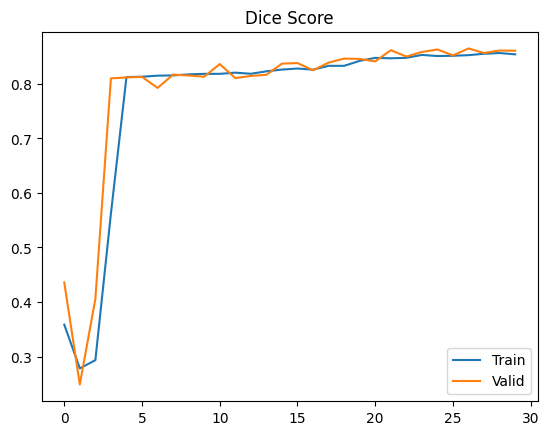

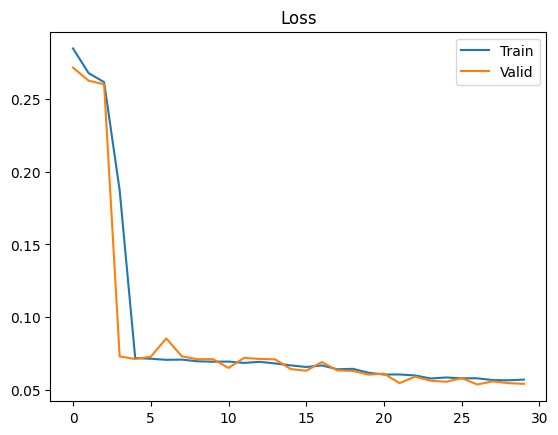

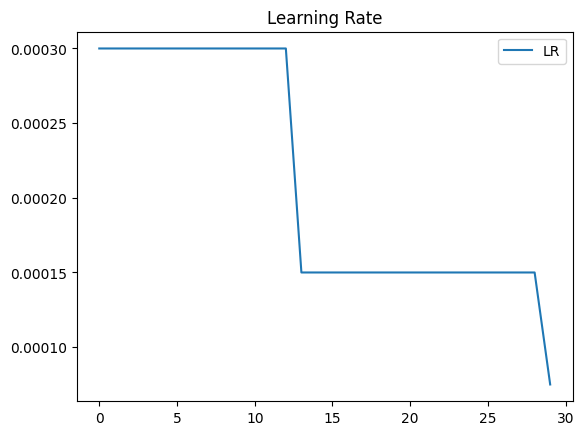

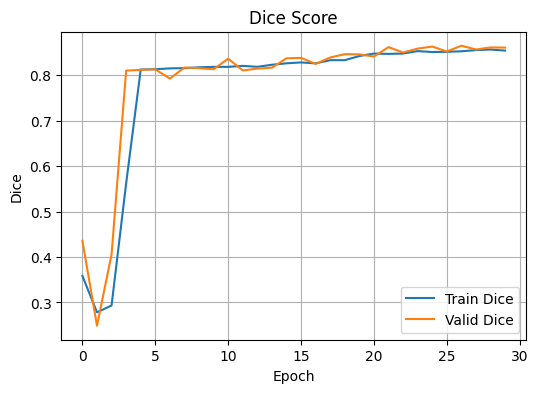

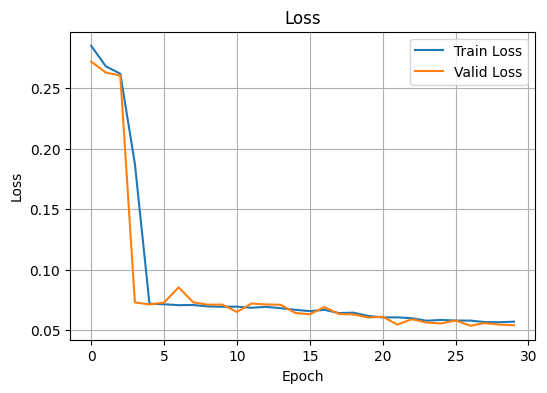

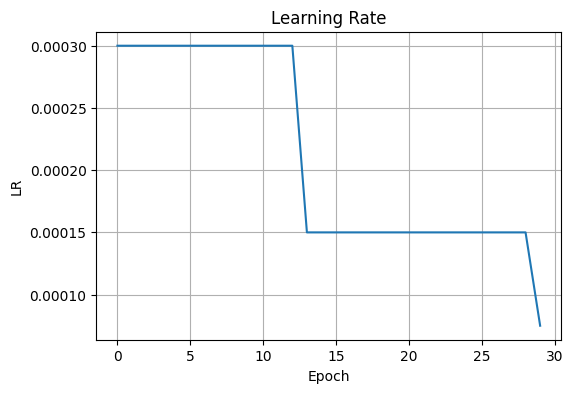

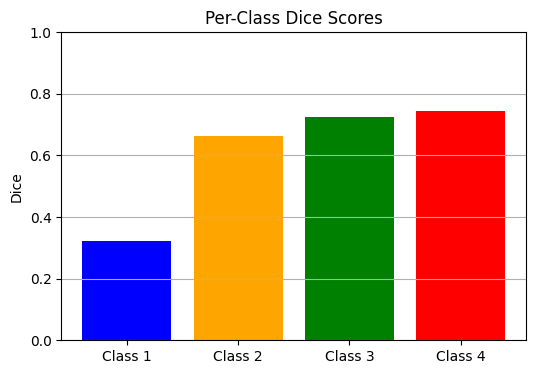

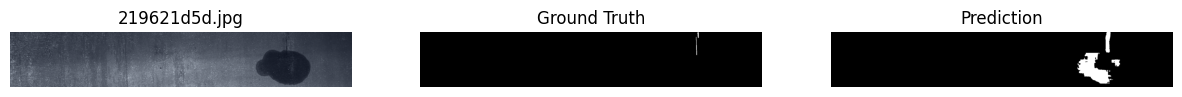

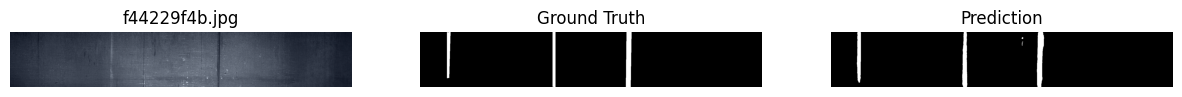

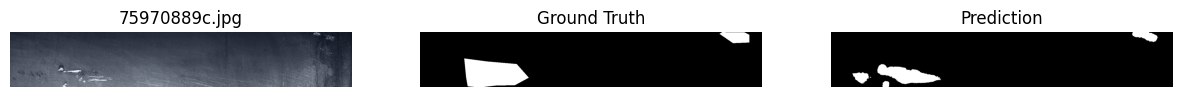

In [16]:
# Model, loss, optimizer, scheduler tanımla
model = UNetResNet18(num_classes=CFG["NUM_CLASSES"],
                     pretrained=CFG["PRETRAINED"], 
                     decoder_mode=CFG["DECODER_MODE"]).to(device)

criterion = WeightedFocalDiceLoss(class_weights=[0.12,0.03,0.72,0.11])
optimizer = Adam(model.parameters(), lr=CFG["LR"], weight_decay=CFG["WEIGHT_DECAY"])
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("GPU bulunamadı, CPU’da çalışıyor.")


# Eğitimi başlat ve history yakala
history = fit(model, train_loader, val_loader, optimizer, scheduler, criterion, device,
              num_epochs=CFG["EPOCHS"], early_stopping_patience=6, save_path="best_model.pth")

# Eğitim sonunda son epoch’u da kaydet
torch.save(model.state_dict(), "last_model.pth")

# --- Eğitim sonrası analiz ve görselleştirme ---

# 1) Eğitim süreci grafikleri (loss, dice, lr)
plot_history(history, show=True)        # hem kaydet hem ekranda göster
plot_training_curves(history)           # subplot ile daha şık görünüm

# 2) Sınıf bazında Dice skorları (validation set üzerinden)
plot_per_class_dice(model, val_loader, device)

# 3) Örnek prediction görselleri (GT vs Pred overlay)
visualize_predictions(model, val_ds, device, k=3)

# En iyi modeli tekrar yüklemek için yol
best_path = "best_model.pth"

### 🧪 Test Dataset ve Inference Hazırlığı  

Bu bölümde eğitimden sonra **test veri seti** hazırlanır ve model ile inference yapılmaya uygun hale getirilir:  

- **SteelDefectTestDataset** sınıfı:  
  - Görüntüler gri ölçekli okunur (`cv2.IMREAD_GRAYSCALE`) ve RGB’ye genişletilir.  
  - Dönüş değeri `(tensor, image_id)` şeklindedir (mask yok).  

- **Test Transform**:  
  - Görüntüler eğitimde kullanılan boyutlara `Resize` ile getirilir.  
  - ImageNet mean/std değerleriyle normalize edilir.  
  - Tensöre dönüştürülür (`ToTensorV2`).  

- **DataLoader**:  
  - `shuffle=False` ayarı ile Kaggle submission sırasında dosya sırası korunur.  
  - `pin_memory=True` ve `num_workers` GPU kullanımını hızlandırır.  

- **Model yükleme**:  
  - `UNetResNet18` tanımlanır, `best_model.pth` checkpoint’i yüklenir.  
  - `.eval()` modunda inference’a hazır hale getirilir.  

Bu adım sonunda, model **test seti üzerinde tahmin yapmaya** hazırdır.  


In [17]:
class SteelDefectTestDataset(Dataset):
    def __init__(self, image_ids, image_dir: Path, transforms=None, load_rgb=True):
        self.image_ids = list(image_ids)
        self.image_dir = image_dir
        self.transforms = transforms
        self.load_rgb = load_rgb

    def __len__(self): return len(self.image_ids)

    def _read_image(self, image_id):
        img = cv2.imread(str(self.image_dir / image_id), cv2.IMREAD_GRAYSCALE)
        if img is None: raise FileNotFoundError(image_id)
        if self.load_rgb: img = np.repeat(img[...,None], 3, axis=2)
        return img

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img = self._read_image(image_id)
        if self.transforms:
            out = self.transforms(image=img)
            img = out["image"]
        else:
            img = torch.from_numpy(img.transpose(2,0,1)).float()
        return img, image_id


# Test transform (sadece normalize & resize)
test_transforms = A.Compose([
    A.Resize(CFG["HEIGHT"], CFG["WIDTH"], interpolation=1),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Test dataset & loader
test_ids = os.listdir(TEST_DIR)
test_ids = [img for img in test_ids if img.endswith(".jpg")]

test_ds = SteelDefectTestDataset(test_ids, TEST_DIR, transforms=test_transforms)
test_loader = DataLoader(test_ds, batch_size=CFG["BATCH_SIZE"],
                         shuffle=False, num_workers=CFG["NUM_WORKERS"], pin_memory=True)


# Model yükle
model = UNetResNet18(num_classes=CFG["NUM_CLASSES"],
                     pretrained=False, decoder_mode=CFG["DECODER_MODE"])
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device).eval()


UNetResNet18(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

### 📤 Submission Hazırlama

- Model test verisi üzerinde tahmin üretir (`eval` modunda).  
- Çıkışlar `sigmoid` → threshold ile ikili maskeye çevrilir.  
- Her sınıf için maskeler **RLE** formatında encode edilir.  
- Sonuçlar `ImageId, ClassId, EncodedPixels` kolonları ile DataFrame’e yazılır.  
- Boş maskeler `NaN` yapılır ve `submission.csv` dosyası oluşturulur.  


In [ ]:
sub = []

with torch.no_grad():
    for imgs, image_ids in tqdm(test_loader, desc="Inference"):
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > CFG["THRESHOLD"]).float().cpu().numpy()

        # (B, C, H, W) -> her image, her class için RLE encode
        for i in range(preds.shape[0]):
            image_id = image_ids[i]
            for c in range(CFG["NUM_CLASSES"]):
                mask = preds[i, c]
                # geri H,W formatına çevrilmiş mask
                mask = (mask > 0.5).astype(np.uint8)
                rle = rle_encode(mask)
                sub.append([image_id, c+1, rle])

# DataFrame oluştur
sub_df = pd.DataFrame(sub, columns=["ImageId","ClassId","EncodedPixels"])

# Kaggle formatı: boş maskeler için NaN olmalı
sub_df.loc[sub_df["EncodedPixels"]=="", "EncodedPixels"] = np.nan

# Kaydet
sub_df.to_csv("submission.csv", index=False)
print("✅ submission.csv hazır:", sub_df.shape)


Inference:   9%|▉         | 65/689 [00:09<01:25,  7.32it/s]

### 13) Niteliksel Değerlendirme (Code)

Eğitim sonrası, modelin tahmin performansını yalnızca metriklerle değerlendirmek yeterli olmayabilir. Niteliksel analiz için bazı örnek görüntüler üzerinde:

* Orijinal girdi resmi

* Gerçek (GT) maske

* Modelin tahmini maske çıktısı

yan yana görselleştirilir. Böylece modelin hangi sınıfları doğru/yanlış segmentlediği görsel olarak incelenebilir.

In [ ]:
@torch.no_grad()
def visualize_samples(model, dataset, k=3, thr=CFG["THRESHOLD"]):
    model.eval()
    idxs = np.random.choice(len(dataset), size=min(k, len(dataset)), replace=False)
    for i in idxs:
        img, mask, meta = dataset[i]   # Dataset __getitem__ -> (image, mask, meta)
        x = img.unsqueeze(0).to(device)
        pred = torch.sigmoid(model(x))[0].cpu().numpy().transpose(1,2,0)
        pred_bin = (pred > thr).astype(np.uint8)

        img_np  = img.permute(1,2,0).numpy()
        mask_np = mask.permute(1,2,0).numpy()

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow((img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8))
        axs[0].set_title(meta["image_id"]); axs[0].axis("off")
        axs[1].imshow(mask_np.max(-1), cmap="gray"); axs[1].set_title("GT any"); axs[1].axis("off")
        axs[2].imshow(pred_bin.max(-1), cmap="gray"); axs[2].set_title("Pred any"); axs[2].axis("off")
        plt.show()

# En iyi kaydedilmiş modeli yükle
model.load_state_dict(torch.load(best_path, map_location=device))
visualize_samples(model, val_ds, k=3)
